In [44]:
import torch,torchvision
from torch import nn
import pandas as pd
import tqdm
import numpy as np


In [45]:
import matplotlib.pyplot as plt

In [46]:

train_set = pd.read_csv('./archive/mnist_train.csv')
test_set = pd.read_csv('./archive/mnist_test.csv')

Y_train = train_set.pop('label')

X_train =torch.tensor( train_set.to_numpy(),dtype=torch.float) /255



In [47]:

class vae(nn.Module):
    def __init__(self,input_shape,latent_shape):
        self.input_shape=input_shape
        self.latent_shape=latent_shape
        super(vae,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features= input_shape,out_features=512),
            nn.ReLU(),
            # nn.Linear(in_features=512,out_features=128),
            # nn.ReLU(),
            nn.Linear(in_features= 512,out_features=latent_shape + latent_shape),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_shape,out_features=512),
            nn.ReLU(),
            # nn.Linear(in_features=128,out_features=512),
            # nn.ReLU(),
            nn.Linear(in_features= 512,out_features=input_shape),
            nn.Sigmoid()
        )
        self.Normal = torch.distributions.Normal(0,1)
        self.Normal.loc = self.Normal.loc.cuda()
        self.Normal.scale = self.Normal.scale.cuda()
        self.kl=0

    def forward(self,X : np.ndarray):
        encoded = self.encoder(X)
        zmean,z_log_var = torch.split(tensor=encoded,split_size_or_sections=10,dim=0)
    
        sampled = zmean + self.Normal.sample(zmean.shape)*torch.exp(z_log_var)

        decoded = self.decoder(sampled)

        self.kl = -0.5*(1+z_log_var - zmean**2 - torch.exp(z_log_var)).sum()

        return decoded 
    


In [48]:

def train(varae,X_train,device,epochs=5):
    varae =varae.to(device)
    opt = torch.optim.Adam(varae.parameters(),lr=1e-5)
    for epoch in range(epochs):
        with tqdm.tqdm(total=len(X_train), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
            for x in X_train: 
                x = x.to(device) 
                opt.zero_grad()
                x_hat = varae(torch.tensor(x))
                rl_loss =  nn.functional.binary_cross_entropy(x_hat,x,reduction='sum')
                loss = rl_loss + varae.kl
                loss.backward()
                if torch.isnan(loss):
                    print("NaN loss detected!")
                    print("x_hat:", x_hat.mean().item(), "x:", x.mean().item())
                    break
                opt.step()

                # Update the progress bar
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)  

        print(f'{epoch+1} done ')
    
    return varae


In [49]:
input_shape =  784
latent_shape = 10
model = vae(input_shape,latent_shape)

In [50]:
device = torch.device("cuda")
model =model.to(device)
x = X_train[2]
opt = torch.optim.Adam(model.parameters()) 
x = x.to(device) 
opt.zero_grad()
x_hat = model(torch.tensor(x))
rl_loss =  nn.functional.binary_cross_entropy(x_hat,x,reduction='sum')
loss = rl_loss + model.kl
loss.backward()
if torch.isnan(loss):
    print("NaN loss detected!")
    print("x_hat:", x_hat.mean().item(), "x:", x.mean().item())
opt.step()

/tmp/ipykernel_30822/3062351632.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_hat = model(torch.tensor(x))


In [51]:
#model(X_train[3].to)

In [52]:


device = torch.device("cuda")

trained_model = train(model,X_train[1:10000],device)

Epoch 1/5:   0%|          | 0/9999 [00:00<?, ?batch/s]/tmp/ipykernel_30822/1181022606.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_hat = varae(torch.tensor(x))
Epoch 1/5: 100%|██████████| 9999/9999 [00:51<00:00, 193.34batch/s, loss=172]


1 done 


Epoch 2/5: 100%|██████████| 9999/9999 [00:54<00:00, 182.86batch/s, loss=165] 


2 done 


Epoch 3/5: 100%|██████████| 9999/9999 [00:49<00:00, 201.40batch/s, loss=165] 


3 done 


Epoch 4/5: 100%|██████████| 9999/9999 [00:49<00:00, 200.96batch/s, loss=157] 


4 done 


Epoch 5/5: 100%|██████████| 9999/9999 [00:49<00:00, 200.33batch/s, loss=144] 

5 done 


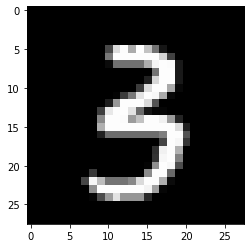

In [53]:
img = X_train[30002].reshape(28,28)
plt.imshow(img,cmap='gray')
plt.show()

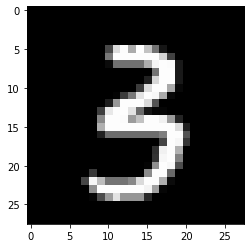

In [54]:
recons_img = model(X_train[30002].to(device)).reshape(28,28)
plt.imshow(img,cmap='gray')
plt.show()

/tmp/ipykernel_30822/1889368914.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(decoded.reshape(28,28).to(torch.device('cpu')))
/tmp/ipykernel_30822/1889368914.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img2 = torch.tensor(decoded_mean.reshape(28,28).to(torch.device('cpu')))


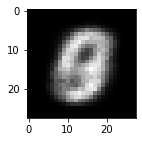

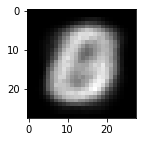

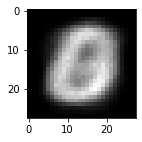

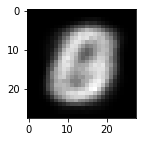

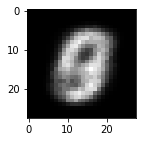

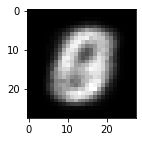

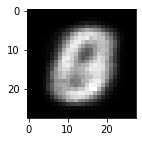

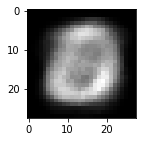

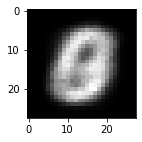

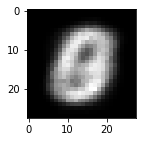

In [75]:
mean,log_var = torch.split(model.encoder(X_train[1].to(device)),split_size_or_sections=10)
sample = model.Normal.sample_n(10)
for samples in sample:
    vector = mean + samples*torch.exp(log_var)
    decoded_mean = model.decoder(torch.exp(log_var).to(device))
    decoded = model.decoder(vector.to(device))
    img = torch.tensor(decoded.reshape(28,28).to(torch.device('cpu')))
    img2 = torch.tensor(decoded_mean.reshape(28,28).to(torch.device('cpu')))
    plt.figure(figsize=(5,2))
    plt.imshow( img,cmap='gray')


    